<a href="https://colab.research.google.com/github/hr1588/dacon/blob/main/%EC%98%A4%EB%8A%98%EC%9D%98_%ED%8C%8C%EC%9D%B4%EC%8D%AC%20-%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

In [3]:
# 레드 와인데이터셋 불러오기
red = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
# 화이트 와인데이터셋 불러오기
white = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

In [5]:
# 데이터 확인
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
# 결측치 확인
red.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [8]:
white.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
# 일반적으로 와인 퀄리티가 와인의 종류를 구분하지 않기 때문에 quality 변수 제거
red = red.drop(['quality'], axis = 1)
white = white.drop(['quality'], axis = 1)

## 이상치 시각화(boxplot)

In [20]:
def boxplot_vis(data, target_name):
    plt.figure(figsize=(30, 30))
    for col_idx in range(len(data.columns)):
        # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(6, 2, col_idx+1)
        # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
        plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        # 그래프 타이틀: feature name
        plt.title("Feature" + "(" + target_name + "):" + data.columns[col_idx], fontsize = 20)
    plt.show()

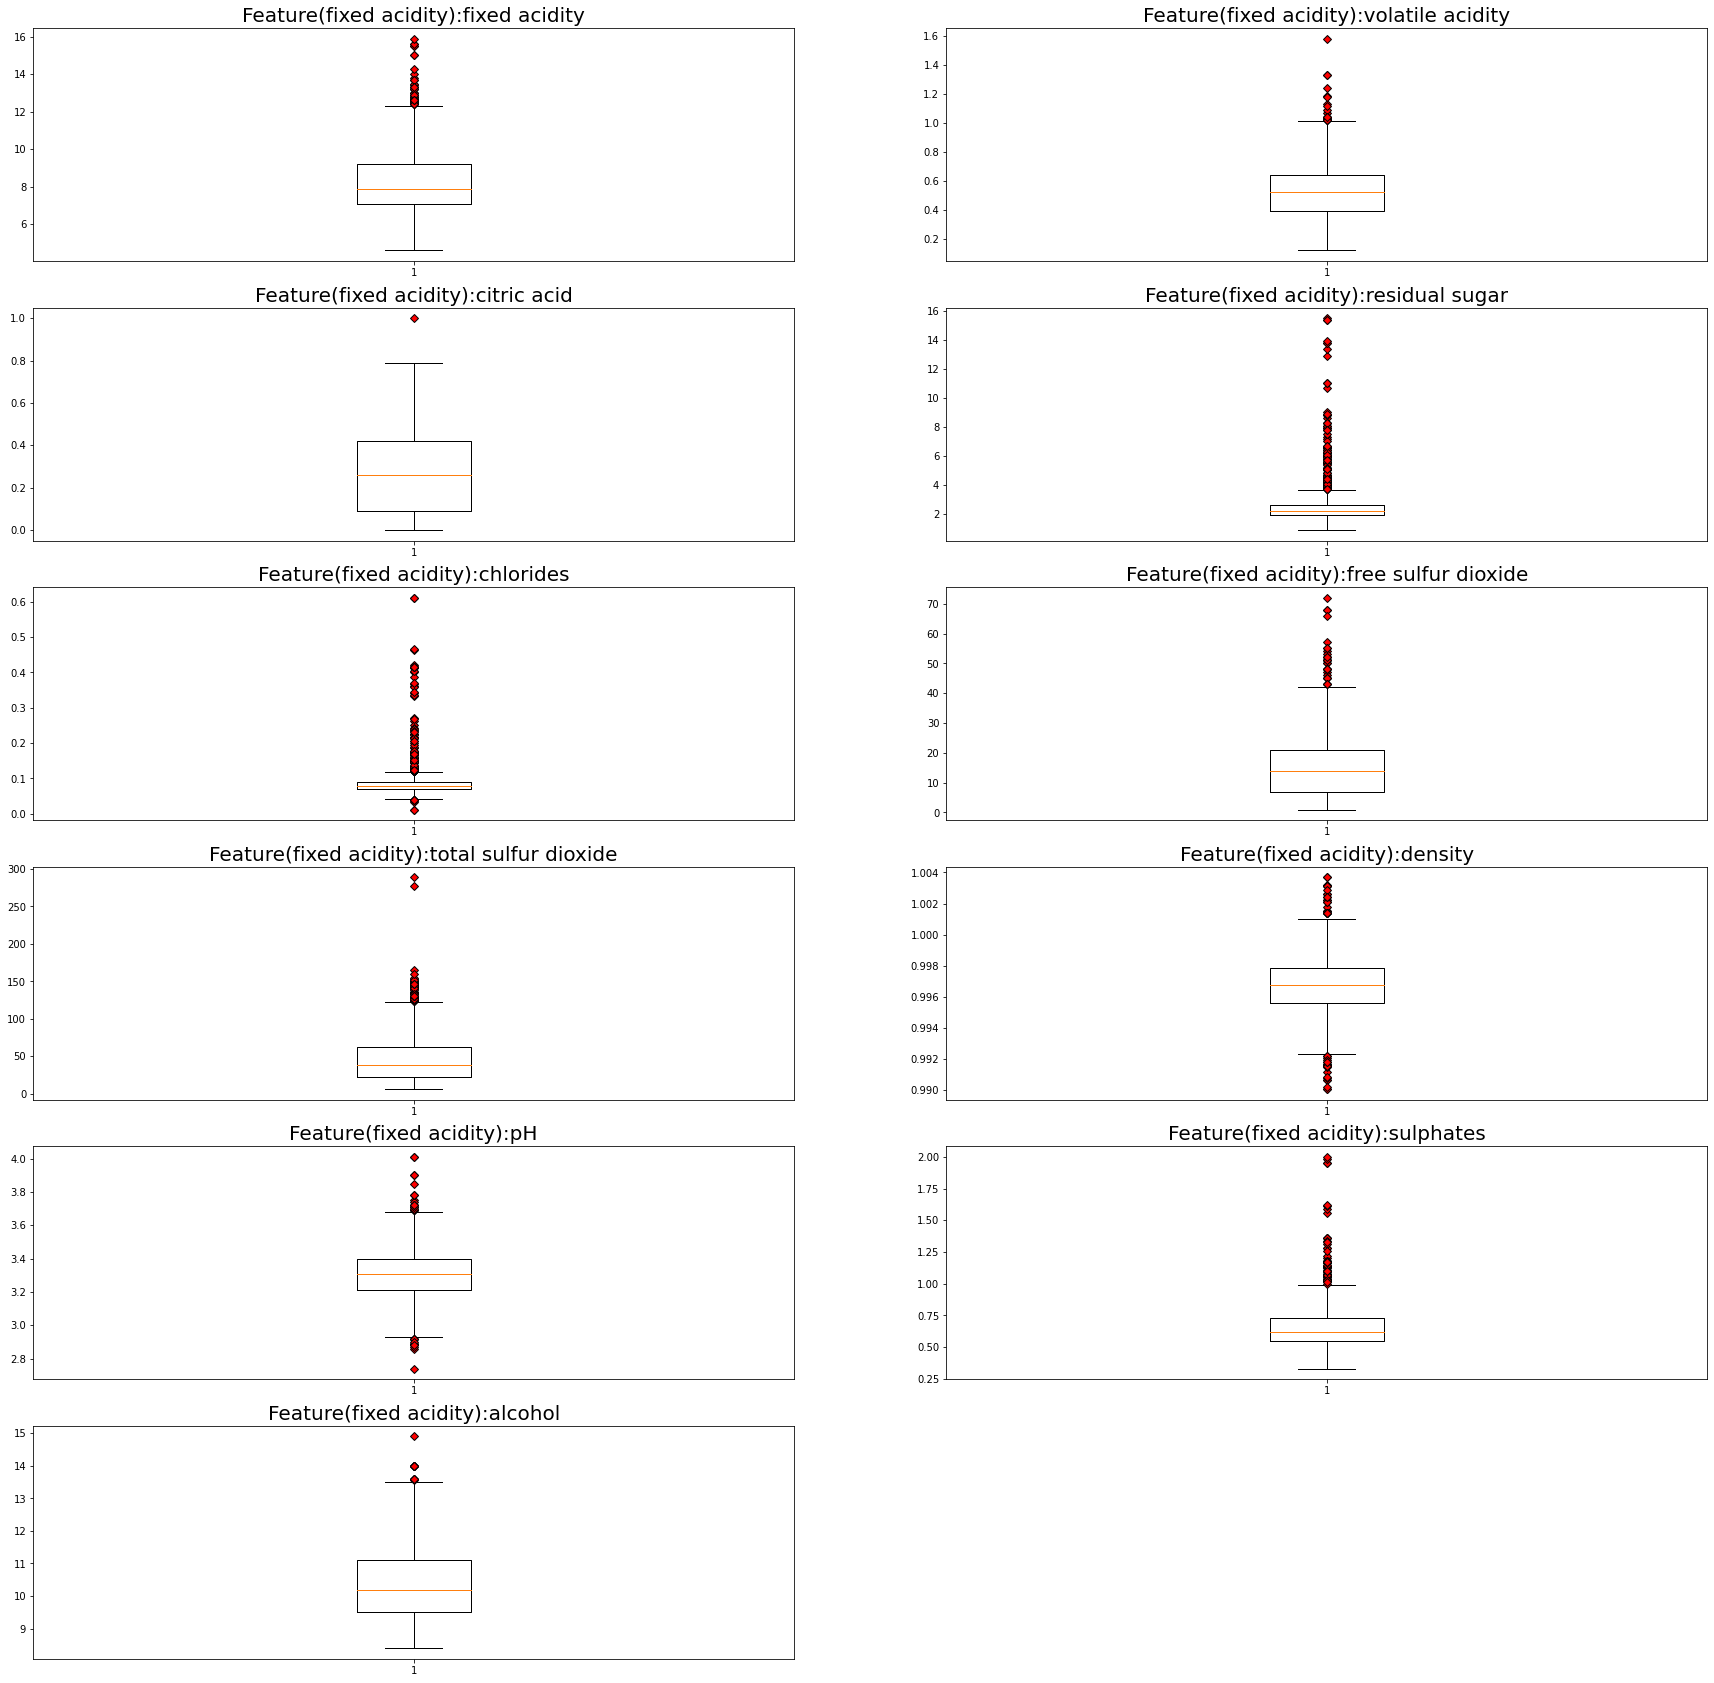

In [24]:
boxplot_vis(red,'fixed acidity')

## 이상치 제거

In [25]:
def remove_outlier(input_data):
    q1 = input_data.quantile(0.25) # 제 1사분위수
    q3 = input_data.quantile(0.75) # 제 3사분위수
    iqr = q3 - q1 # IQR(Interquartile range) 계산
    minimum = q1 - (iqr * 1.5) # IQR 최솟값
    maximum = q3 + (iqr * 1.5) # IQR 최댓값
    # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
    df_removed_outlier = input_data[(minimum < input_data) & (input_data < maximum)]
    return df_removed_outlier

In [28]:
# red 데이터 이상치 제거
red_prep = remove_outlier(red)
# 목표변수 할당
red_prep['target'] = 0
red_prep.isnull().sum()

fixed acidity            49
volatile acidity         19
citric acid               1
residual sugar          155
chlorides               112
free sulfur dioxide      33
total sulfur dioxide     58
density                  45
pH                       35
sulphates                59
alcohol                  14
target                    0
dtype: int64

In [29]:
# 이상치 포함 데이터(이상치 처리 후 NaN) 삭제
red_prep.dropna(axis = 0, how = 'any', inplace = True)
print(f"이상치 포함된 데이터 비율: {round((len(red) - len(red_prep))*100/len(red), 2)}%")

이상치 포함된 데이터 비율: 25.58%


In [31]:
white_prep = remove_outlier(white)
white_prep['target'] = 1
white_prep.isnull().sum()

fixed acidity           146
volatile acidity        186
citric acid             270
residual sugar            7
chlorides               208
free sulfur dioxide      50
total sulfur dioxide     19
density                   5
pH                       75
sulphates               124
alcohol                   0
target                    0
dtype: int64

In [32]:
white_prep.dropna(axis = 0, how = 'any', inplace = True)
print(f"이상치 포함된 데이터 비율: {round((len(white) - len(white_prep))*100/len(white), 2)}%")

이상치 포함된 데이터 비율: 18.37%


## 데이터 병합

In [33]:
df = pd.concat([red_prep, white_prep], axis = 0)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [36]:
df.target.value_counts(normalize=True) # 화이트 와인이 레드 와인보다 약 3배 정도 많음

1    0.770625
0    0.229375
Name: target, dtype: float64

## 설명변수별 목표변수 간의 관계 시각화

In [38]:
x = df[df.columns.difference(['target'])] # 설명변수 설정

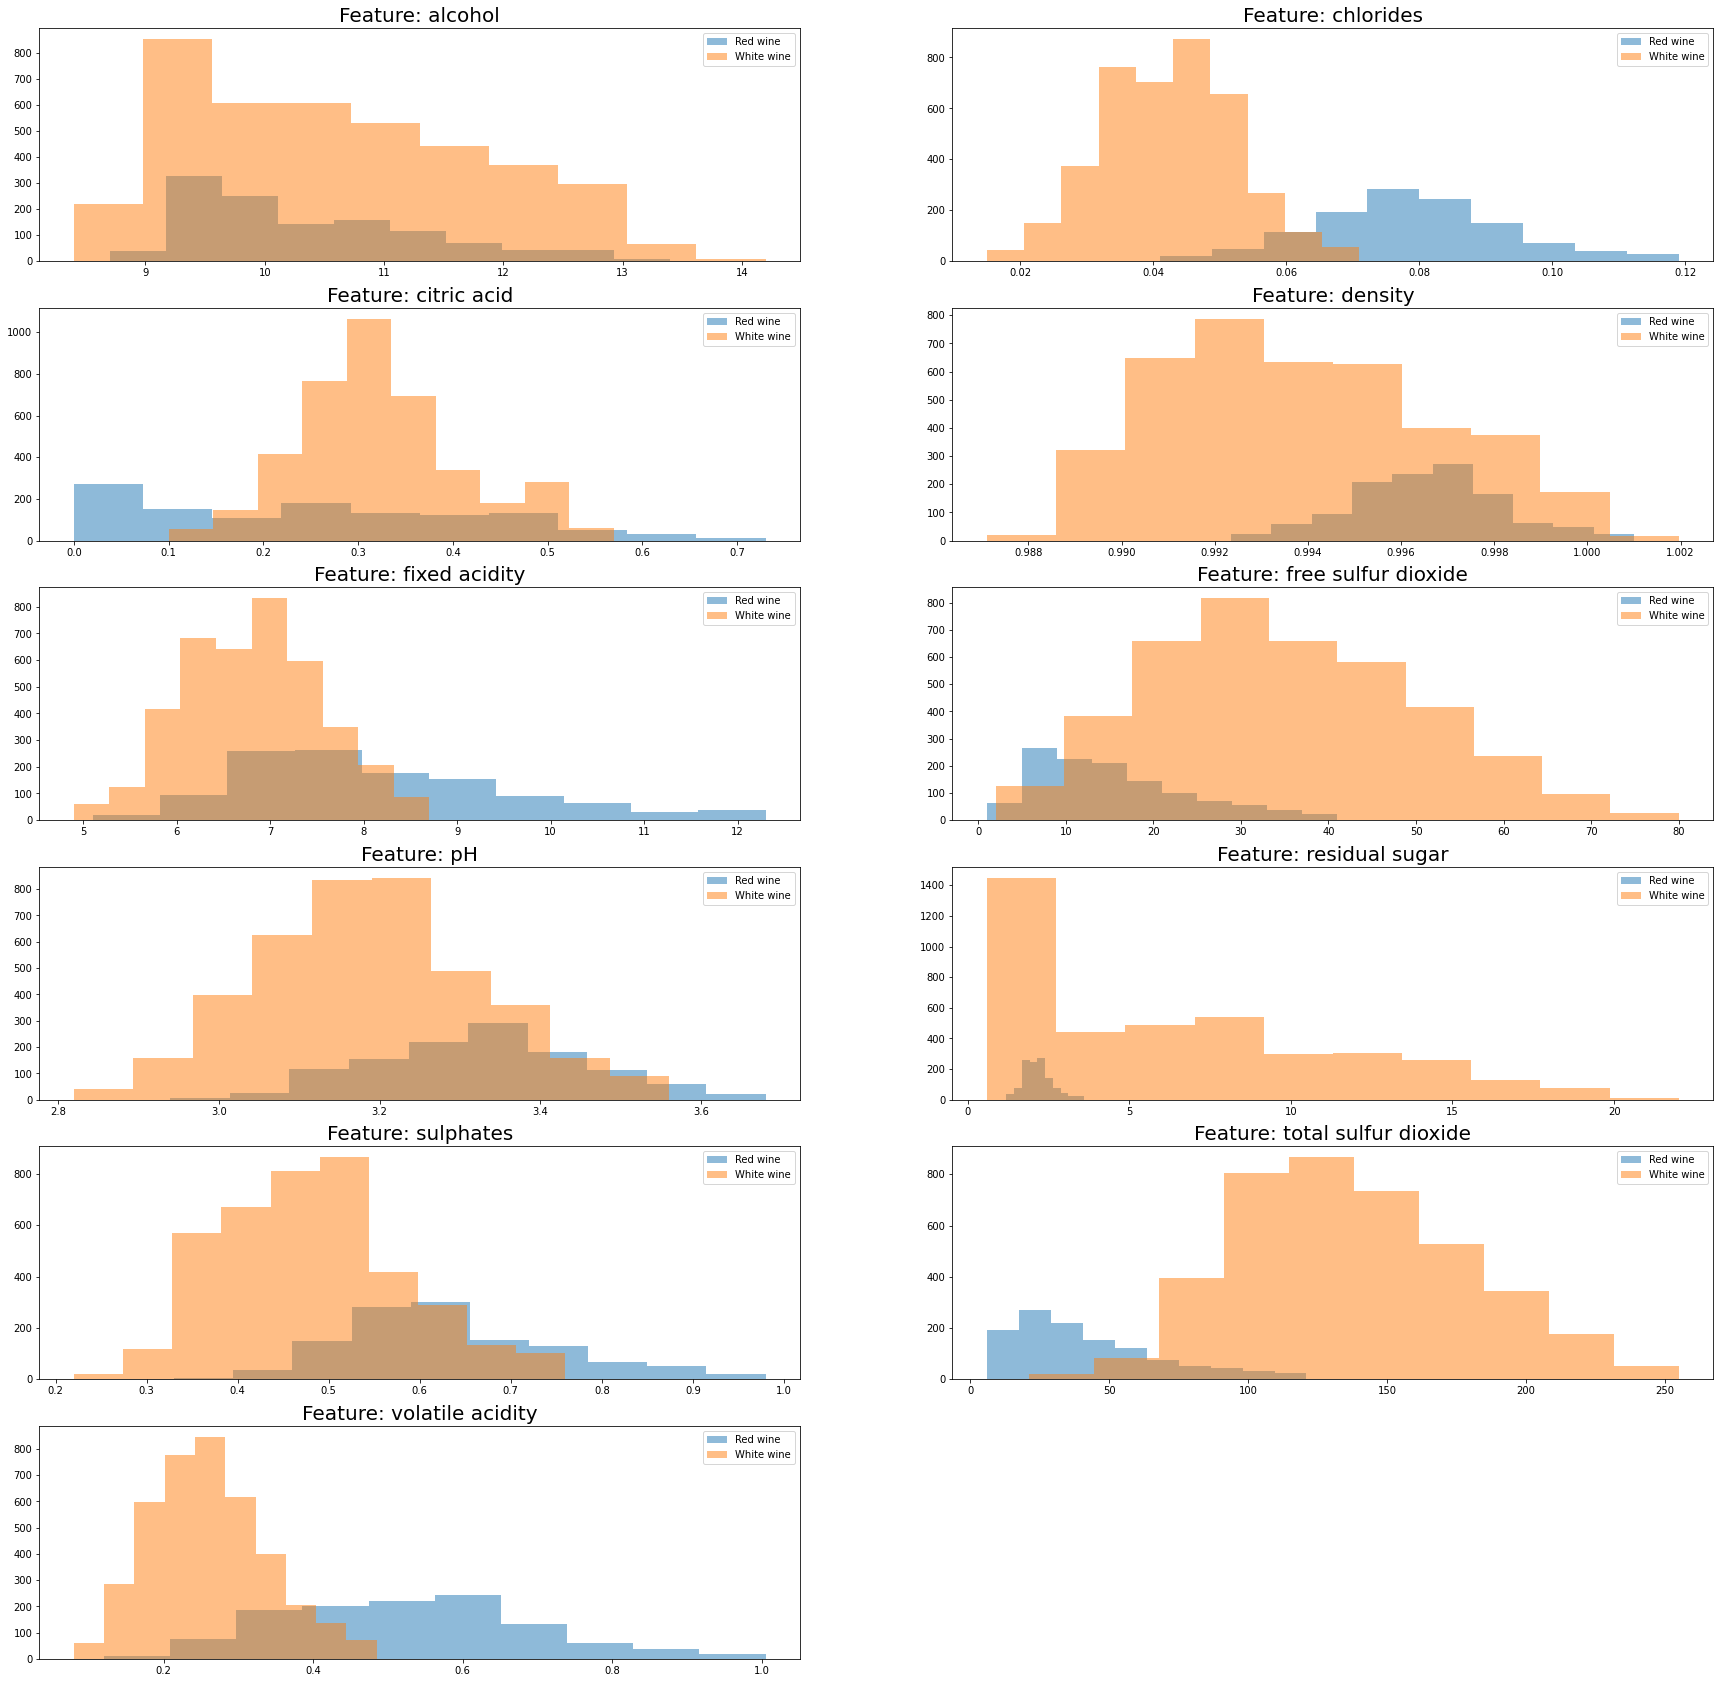

In [40]:
# 설명변수명 리스트
feature_name = x.columns
plt.figure(figsize=(30, 30))
for col_idx in range(len(feature_name)):
    # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
    plt.subplot(6, 2, col_idx+1)
    # 레드 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["target"] == 0][feature_name[col_idx]], label = "Red wine", alpha = 0.5)
    # 화이트 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["target"] == 1][feature_name[col_idx]], label = "White wine", alpha = 0.5)
    plt.legend()
    # 그래프 타이틀: feature name
    plt.title("Feature: "+ feature_name[col_idx], fontsize = 20)
plt.show()

## 데이터 스케일링

In [41]:
# 표준 스케일러(평균 0, 분산 1)
scaler = StandardScaler()
# 설명변수 및 목표변수 분리
x = df[df.columns.difference(['target'])]
y = df['target']
# 설명변수 데이터 스케일링
x_scaled = scaler.fit_transform(x)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.3, random_state = 123)

In [45]:
y_train.value_counts(normalize=True) # 학습 데이터 와인 비율 확인

1    0.767006
0    0.232994
Name: target, dtype: float64

In [46]:
y_test.value_counts(normalize=True) # 테스트 데이터 와인 비율 확인

1    0.779062
0    0.220938
Name: target, dtype: float64

## Classifier 모델링 함수(하이퍼 파라미터 설정)

1. 기본 - 하이퍼 파라미터 튜닝 X

In [47]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

2. 하이퍼 파라미터별 모델 성능 시각화 함수

In [48]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.show()

3. 모델 최적화 함수: 학습할 트리 모델 개수 선정

In [49]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

4. 모델 최적화 함수: 최대 깊이 선정

In [50]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

5. 모델 최적화 함수: 분리 노드의 최소 자료 수 선정

In [51]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

6. 모델 최적화 함수: 잎사귀 노드의 최소 자료 수 선정

In [52]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

- 다음으로 최종 모델 학습 및 오차 행렬, 성능 평가 지표 확인